In [1]:
import tensorflow as tf
import edward as ed
from flows import floatX
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
np.random.seed(1234)

In [2]:
ed.__version__

'1.3.5'

In [3]:
floatX='float32'

In [4]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [5]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.2174228  0.16835931 0.01139835]


In [6]:
xs = data

In [7]:
n = data.shape[1]
s1 = 0.01
s0 = np.sqrt(2.**2 - s1**2)
dim = [3,4]

k = dim[0] * dim[1]

# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')
PWalk = ed.models.Normal(loc=0., scale=[s1]*n*k)
PInit = ed.models.Normal(loc=0., scale=[s0]*k)
# Walk = tf.scan(lambda x, p: x+p, tf.reshape(PWalk, [n, k]), initializer=PInit)
tmp = tf.reshape(PWalk, [n, k])
outs = [PInit]
for i in range(n):
    ap = outs[-1] + tmp[i]
    outs.append(ap)
outs = outs[1:]
Walk = tf.stack(outs)

In [8]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [9]:
outputs = tf.reshape(Walk, [1, n, dim[0]*dim[1]])

In [10]:
def get_preds():
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    ret = []
    for i in range(n-1):
        current = xs[0][i], out[i]
        ret.append(step1(current))
    return tf.stack(ret)
#     ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float32)
#     return ar

In [11]:
preds = get_preds()

In [12]:
preds

<tf.Tensor 'stack_1:0' shape=(19, 3) dtype=float32>

In [13]:
y = ed.models.Normal(loc=preds, scale=1.)

In [14]:
T = 30000
PWalk_q = ed.models.Empirical(tf.get_variable('PWalk_q', initializer=tf.zeros([T,n*dim[0]*dim[1]])))
PInit_q = ed.models.Empirical(tf.get_variable('PInit_q', initializer=tf.zeros([T,dim[0]*dim[1]])))

In [15]:
inference = ed.HMC({PWalk:PWalk_q, PInit:PInit_q}, data={y:xs[0,1:]})

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [28]:
inference.run(step_size=1e-1/4,n_steps=8)

30000/30000 [100%] ██████████████████████████████ Elapsed: 141s | Acceptance Rate: 0.000


In [17]:
PWalk_q, PInit_q = map(ed.models.Empirical, [PWalk_q.get_variables()[0][8000:], PInit_q.get_variables()[0][8000:]])

In [18]:
out = tf.reshape(ed.copy(outputs, {PWalk:PWalk_q, PInit:PInit_q}), [n, dim[0], dim[1]])

In [23]:
samples=[]
for _ in range(3000):
    samples.append(out.eval())
samples = np.array(samples)

# ix = np.random.choice(range(samples.shape[0]), size=3000)
# samples = samples[ix]

In [24]:
samples.shape

(3000, 20, 3, 4)

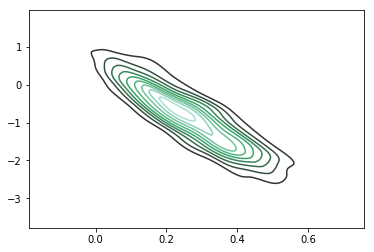

In [25]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

In [22]:
tt = PWalk_q.get_variables()[0].eval()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


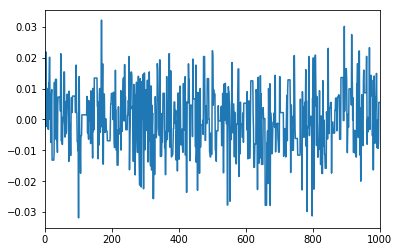

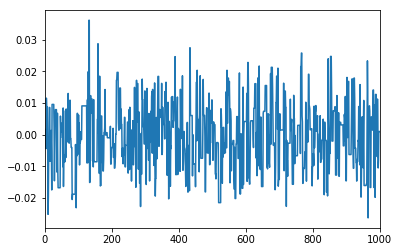

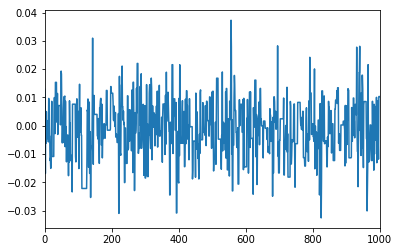

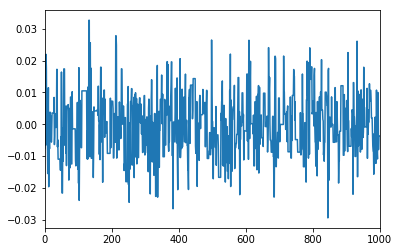

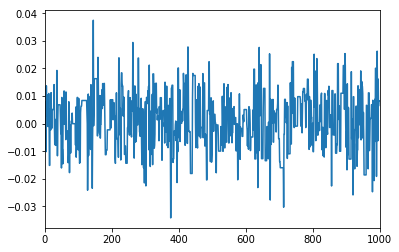

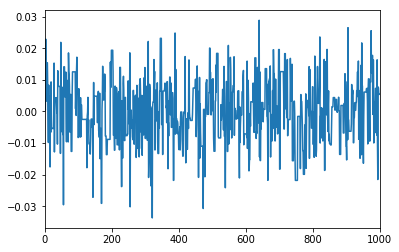

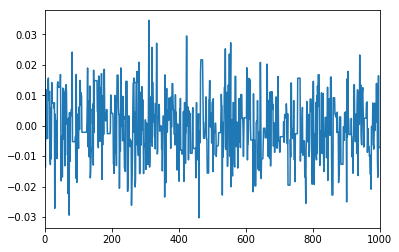

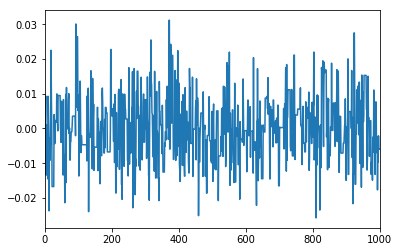

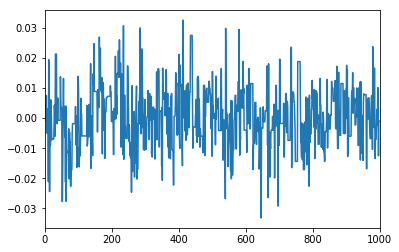

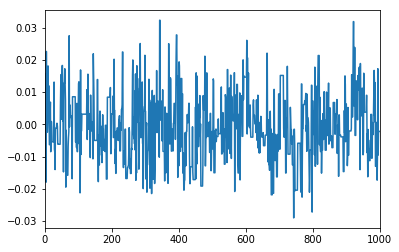

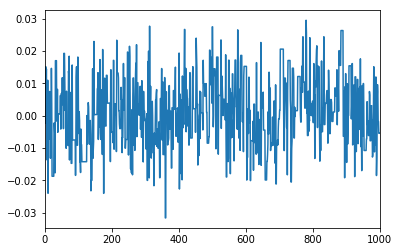

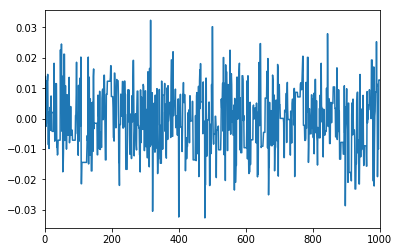

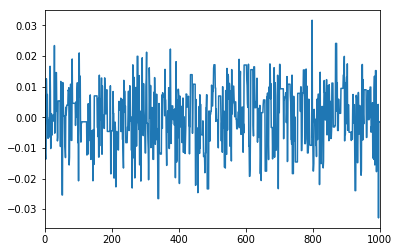

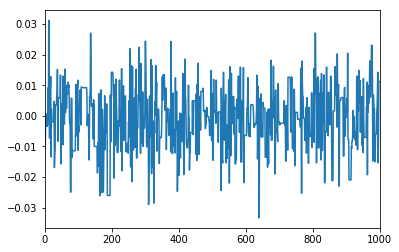

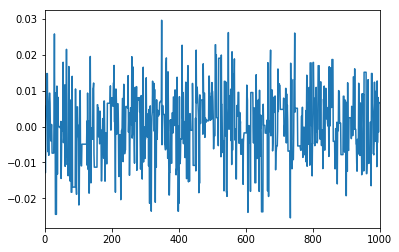

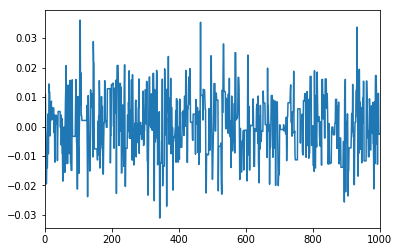

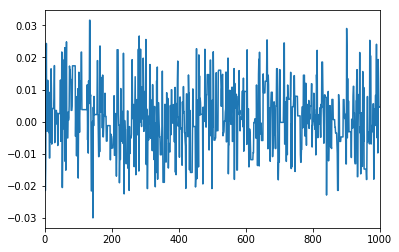

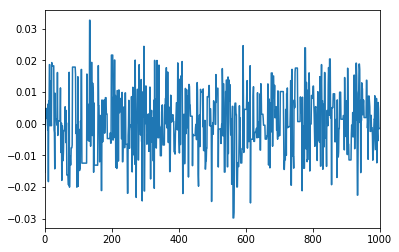

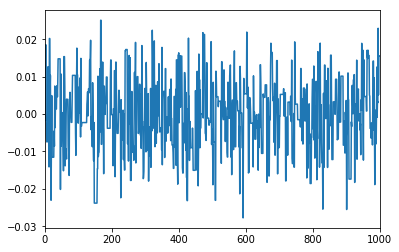

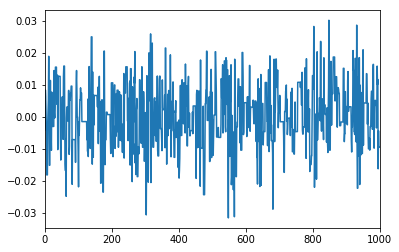

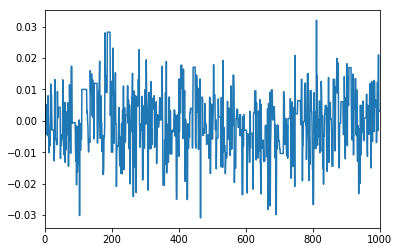

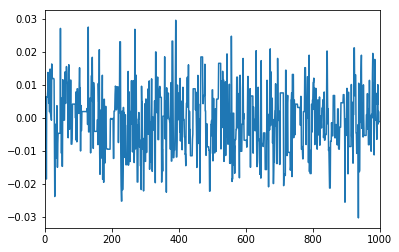

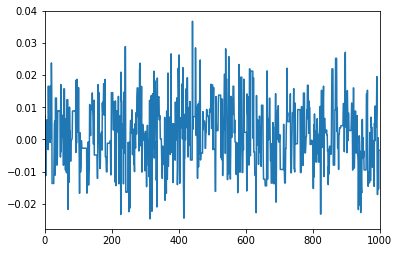

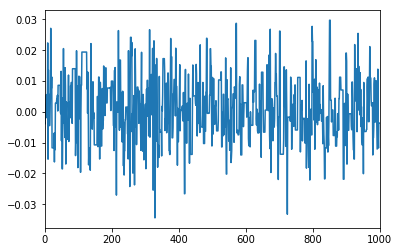

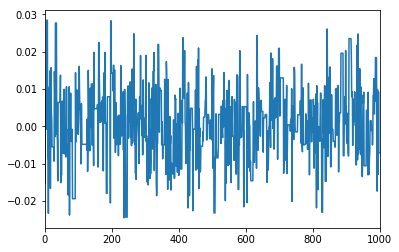

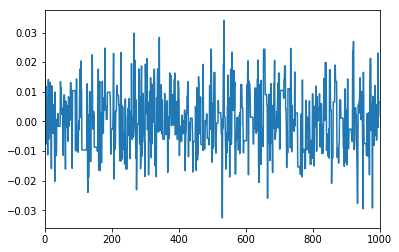

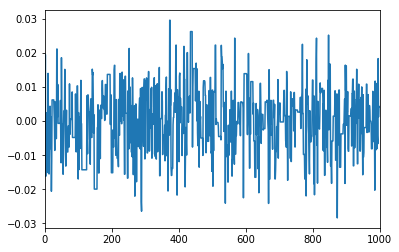

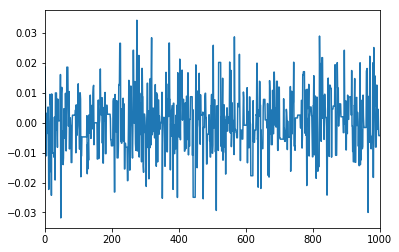

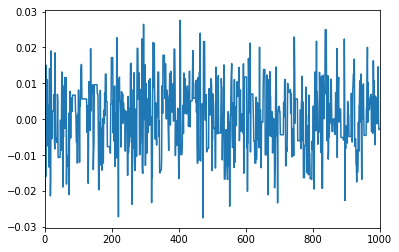

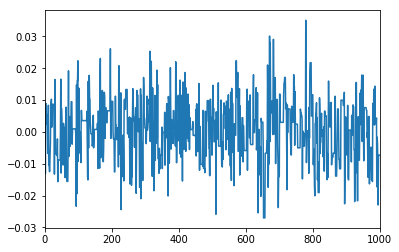

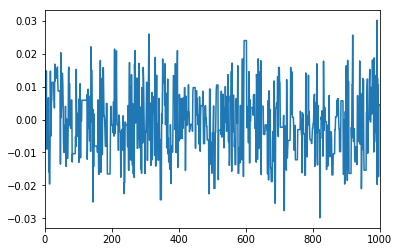

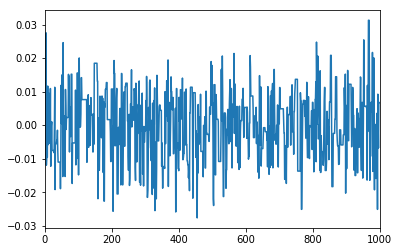

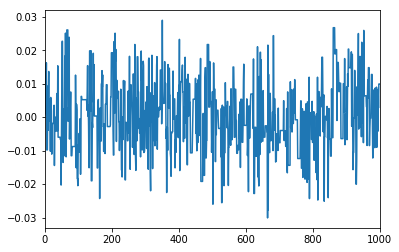

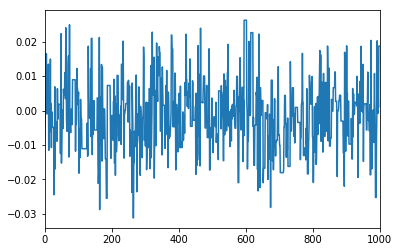

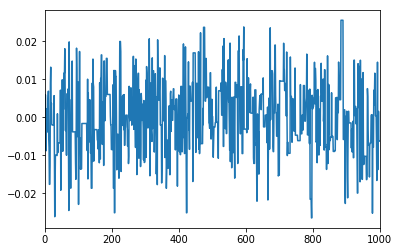

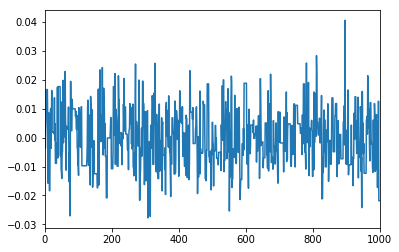

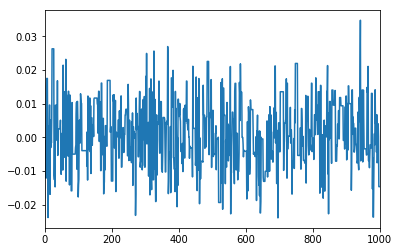

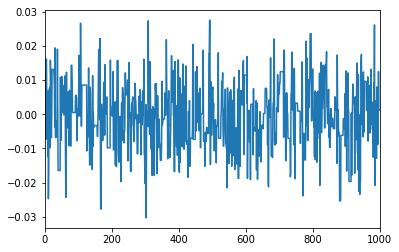

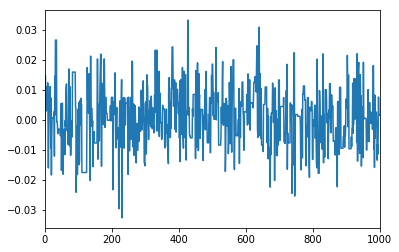

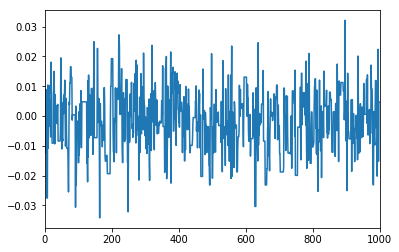

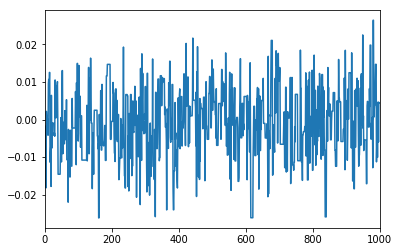

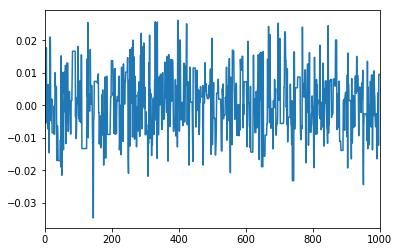

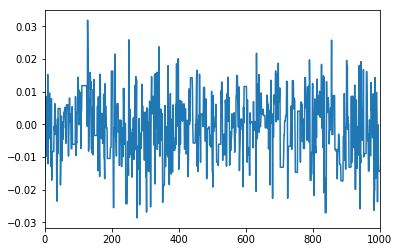

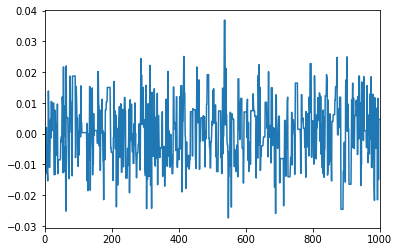

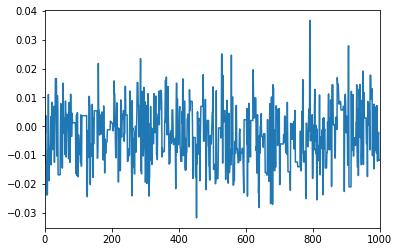

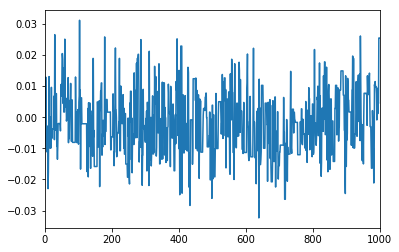

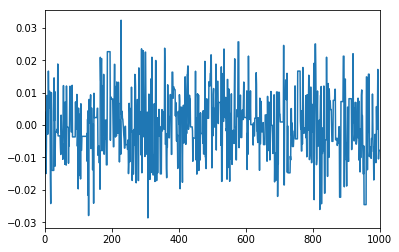

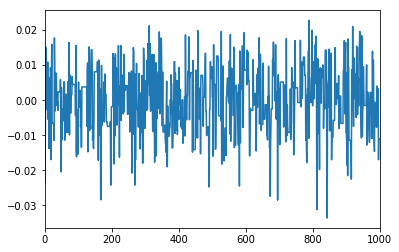

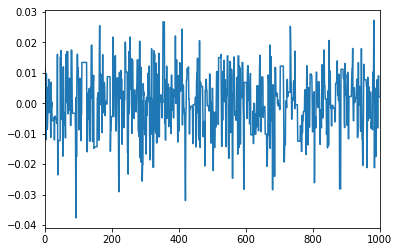

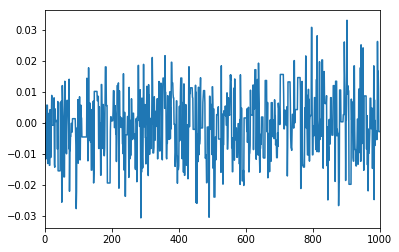

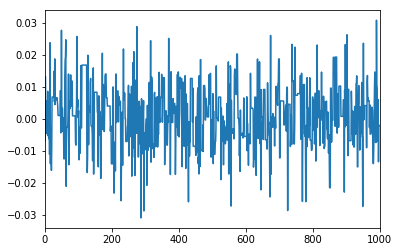

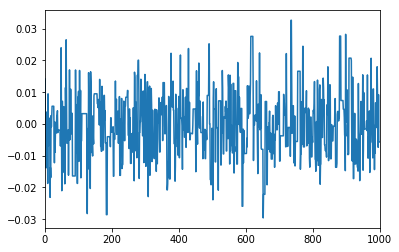

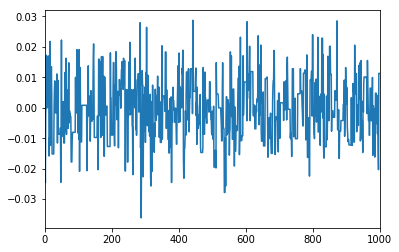

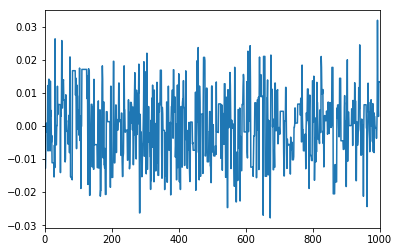

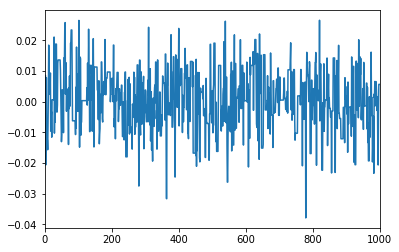

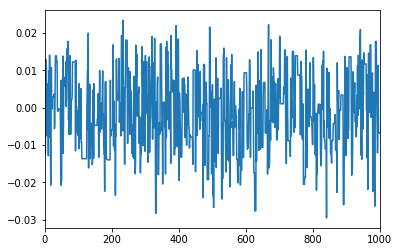

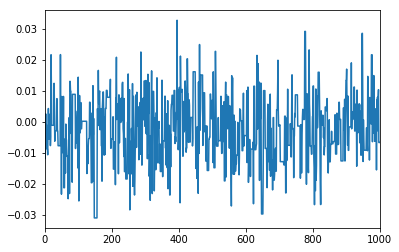

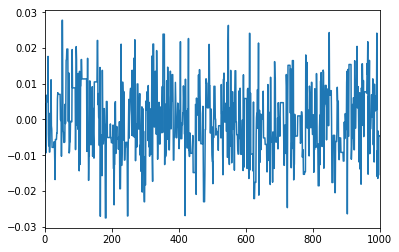

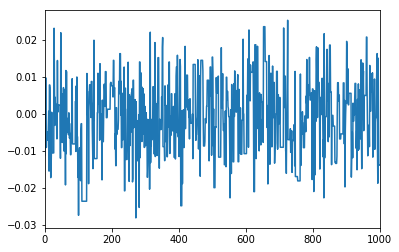

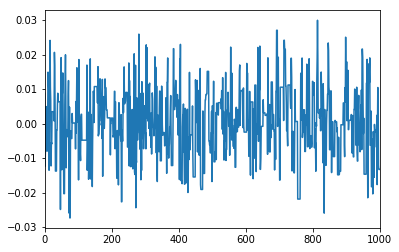

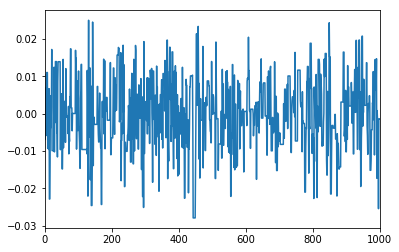

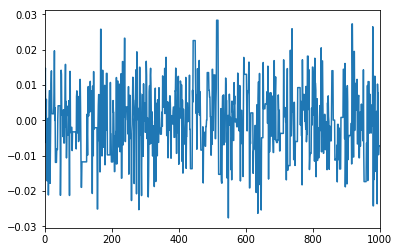

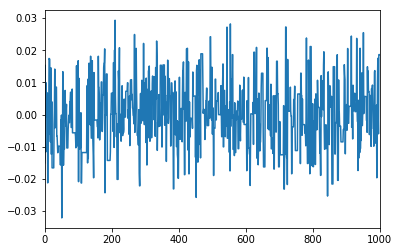

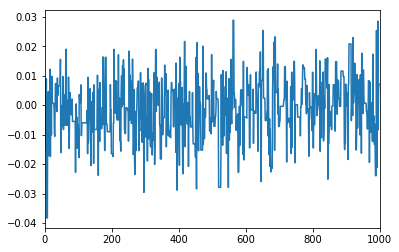

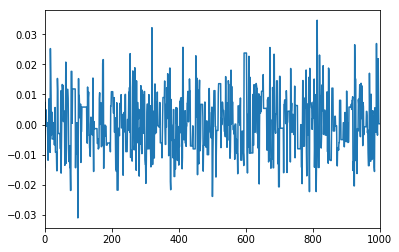

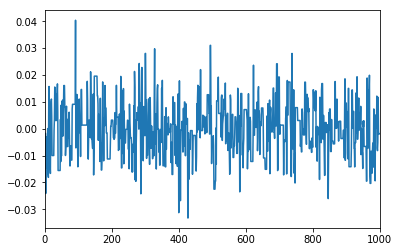

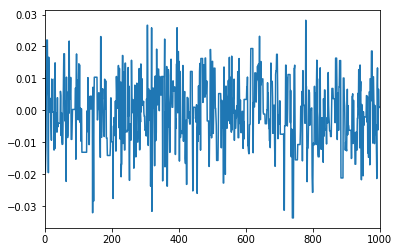

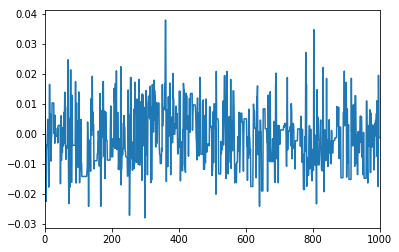

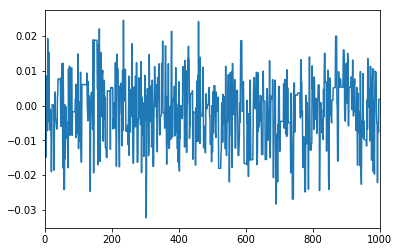

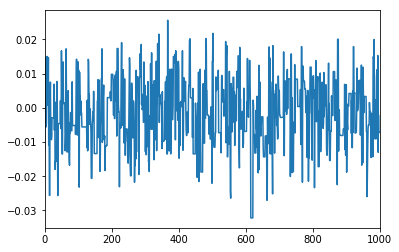

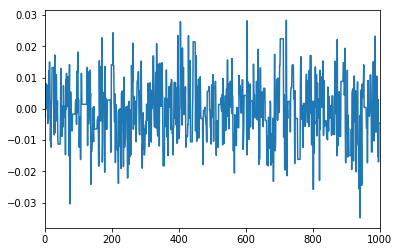

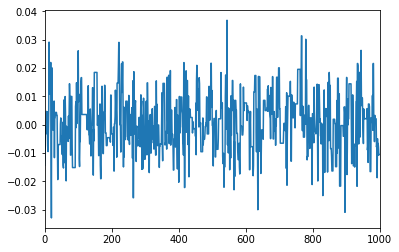

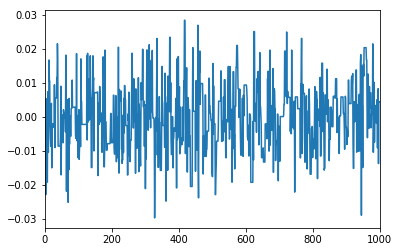

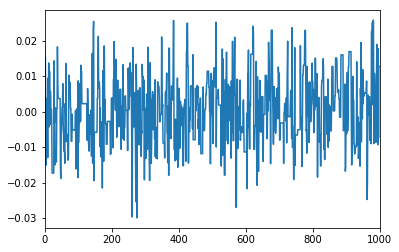

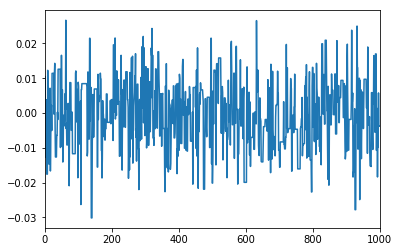

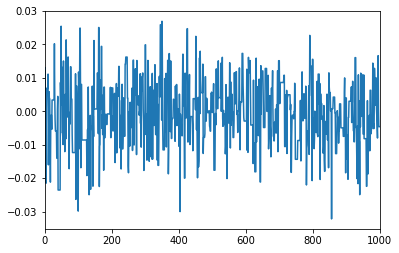

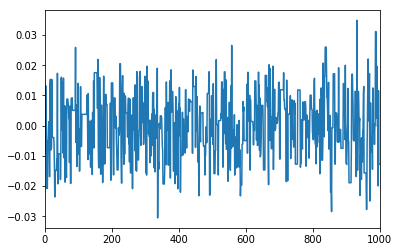

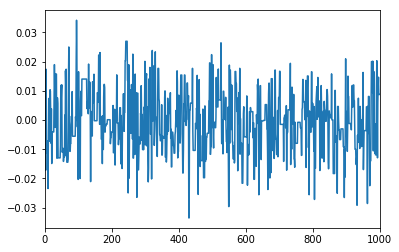

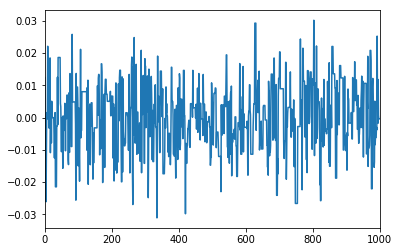

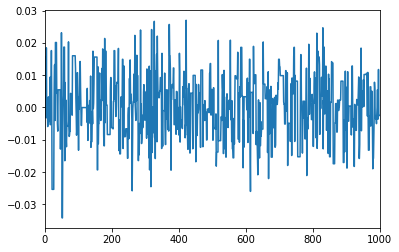

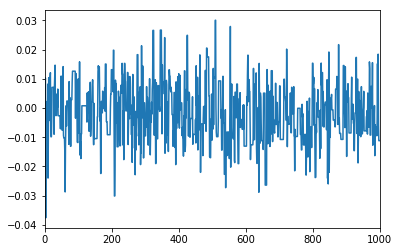

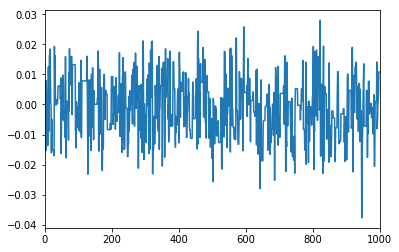

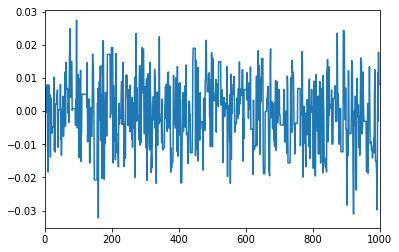

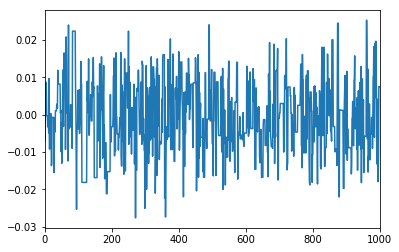

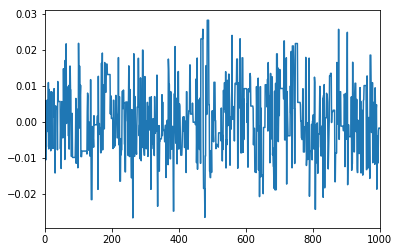

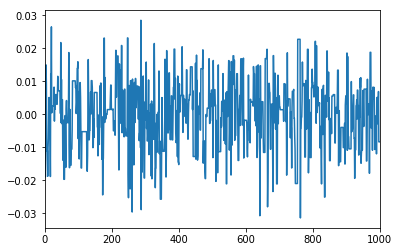

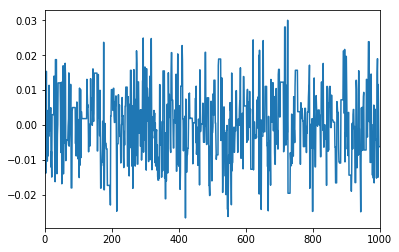

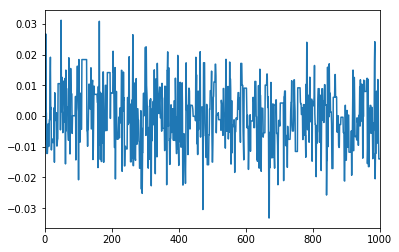

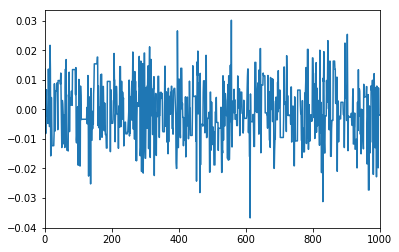

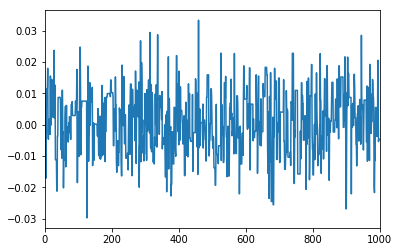

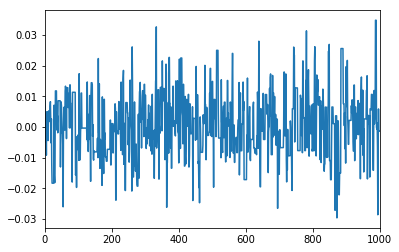

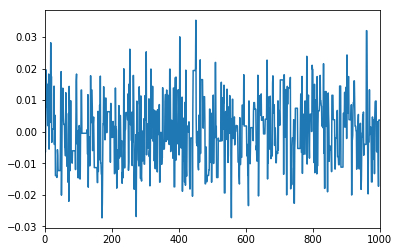

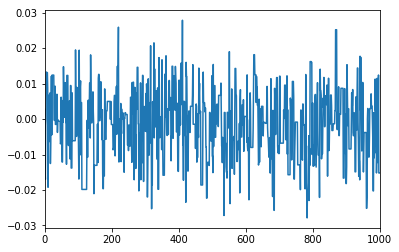

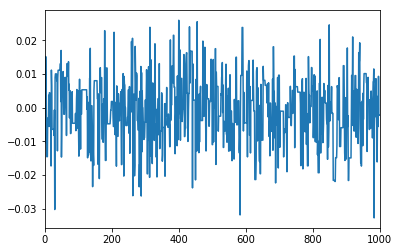

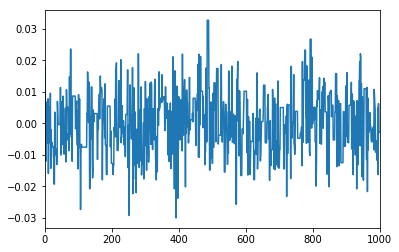

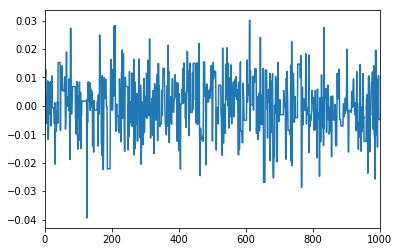

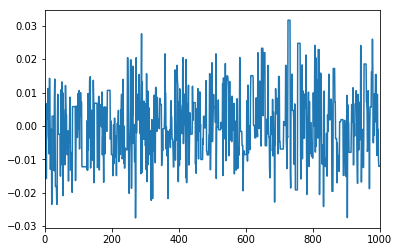

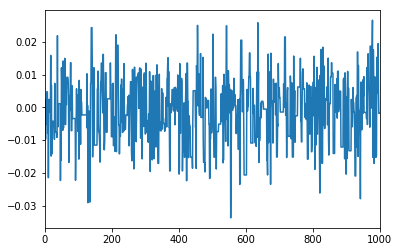

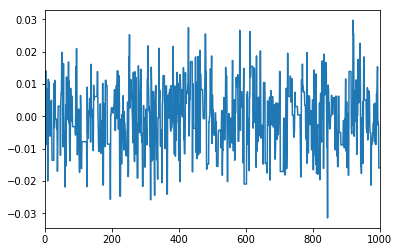

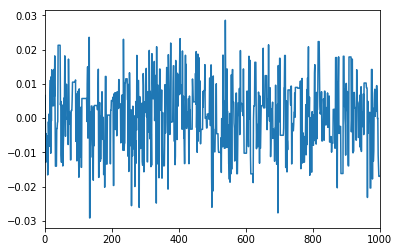

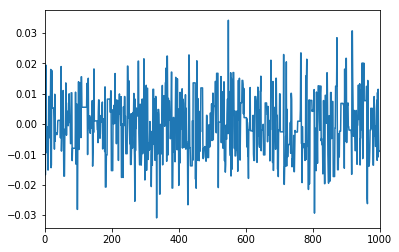

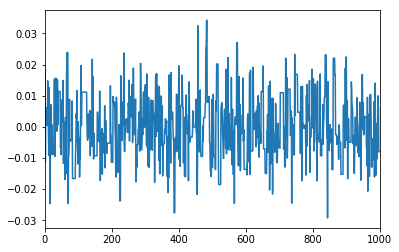

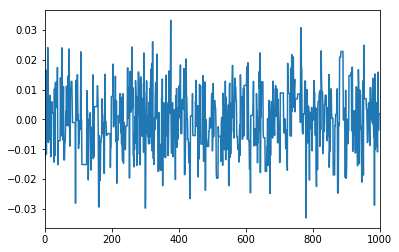

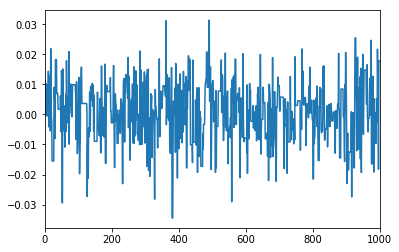

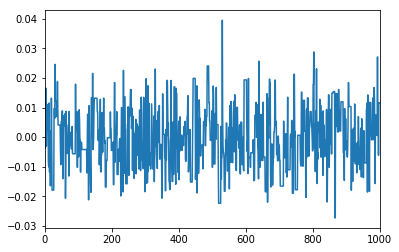

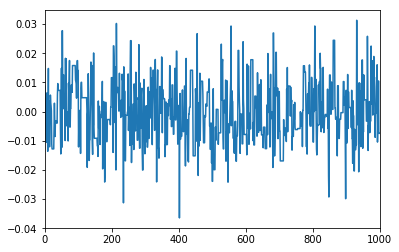

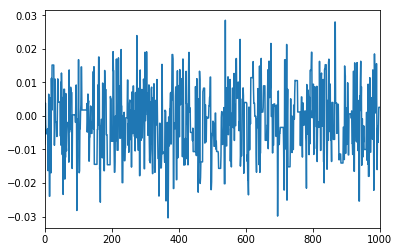

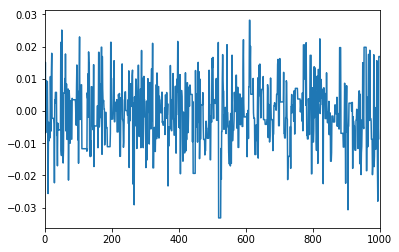

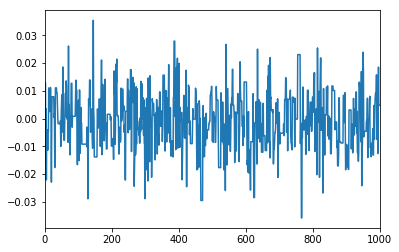

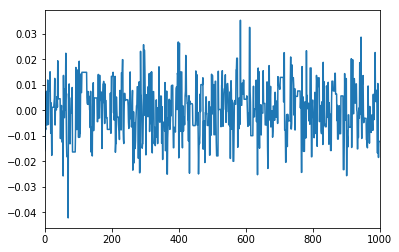

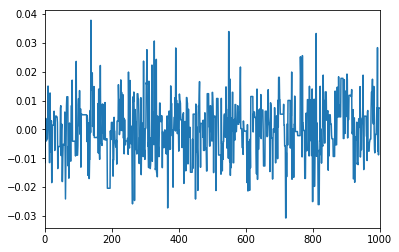

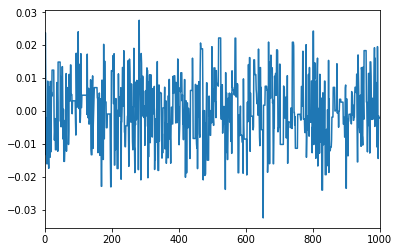

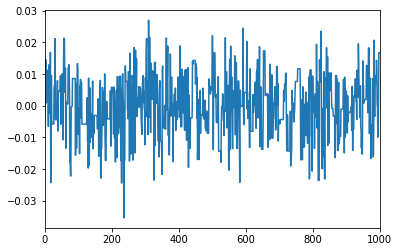

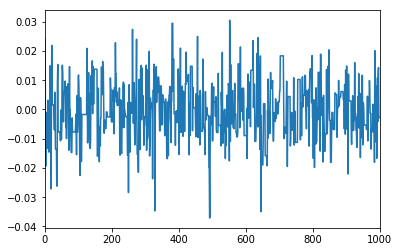

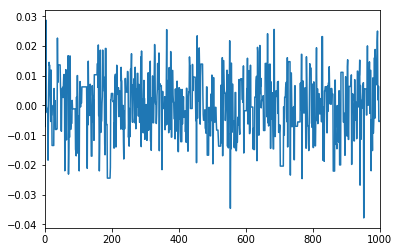

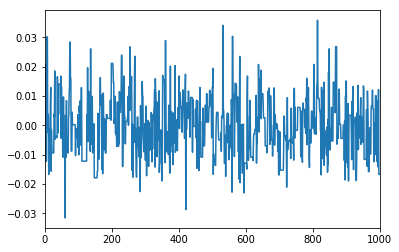

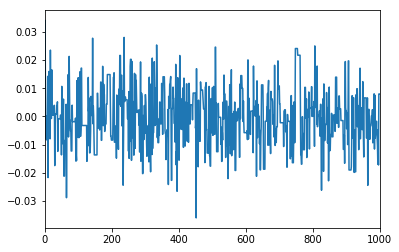

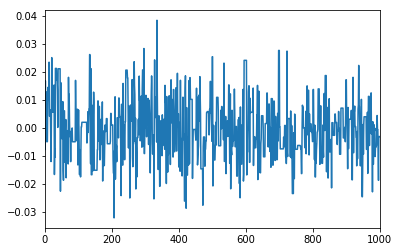

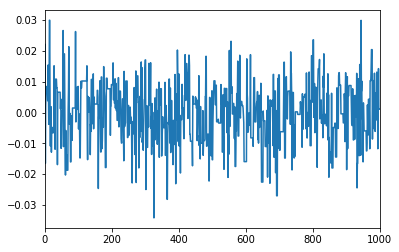

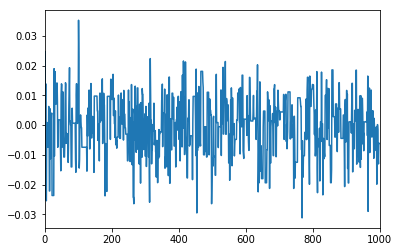

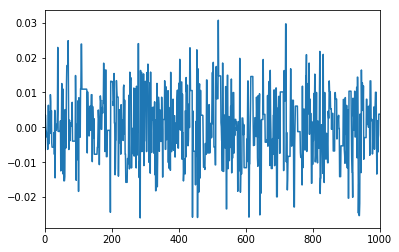

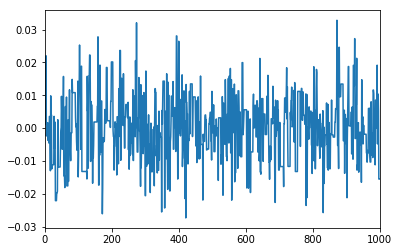

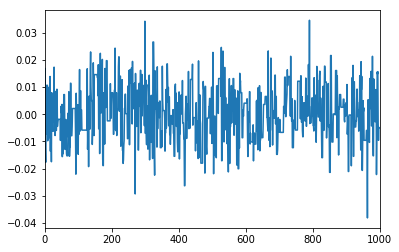

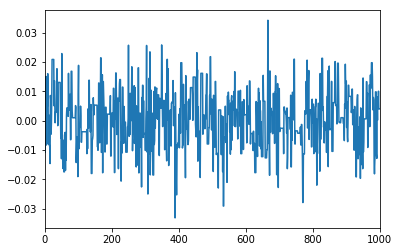

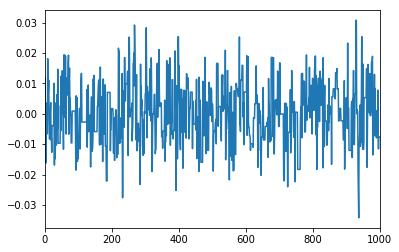

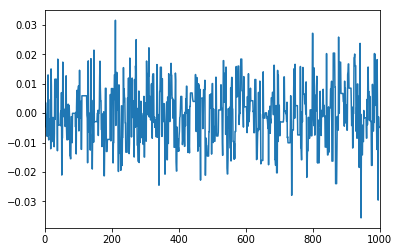

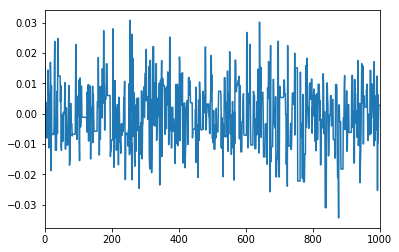

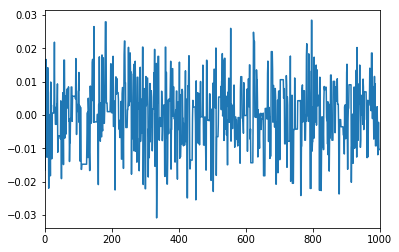

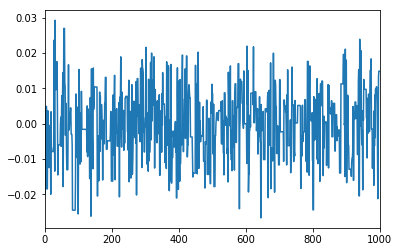

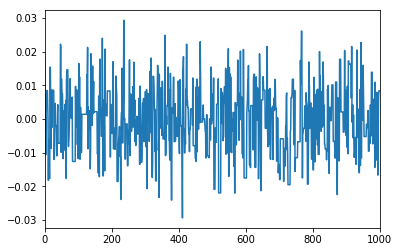

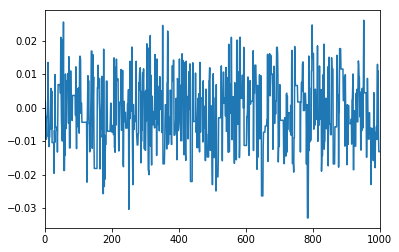

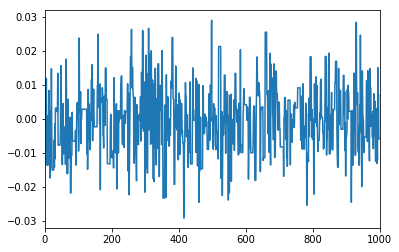

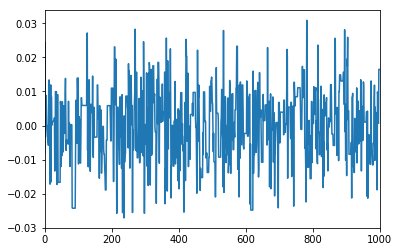

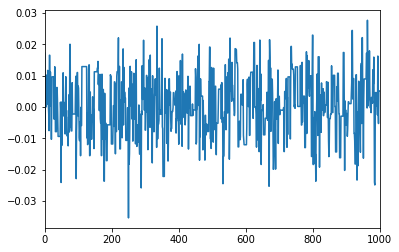

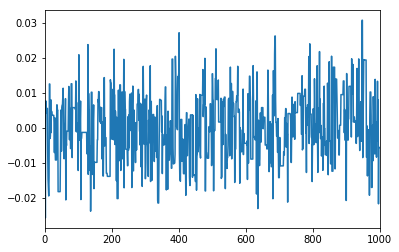

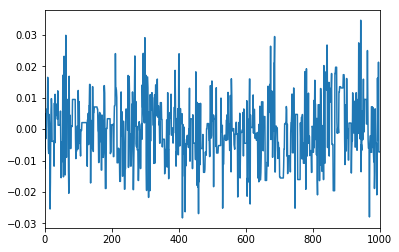

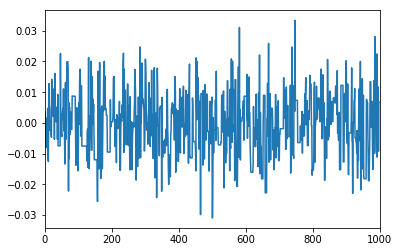

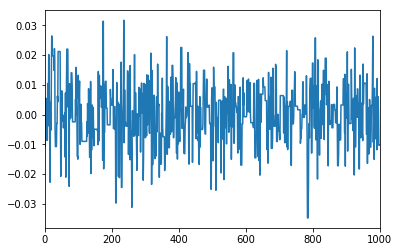

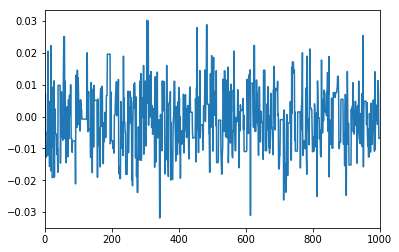

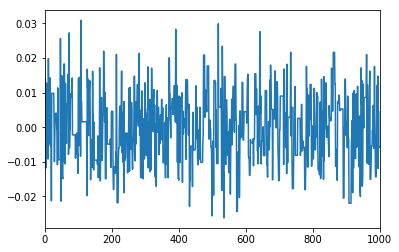

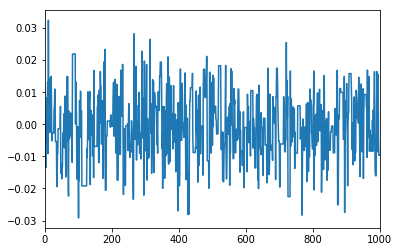

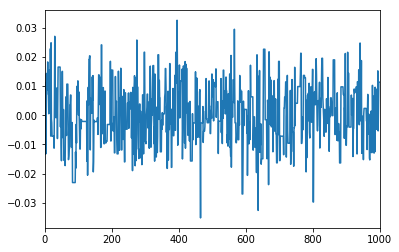

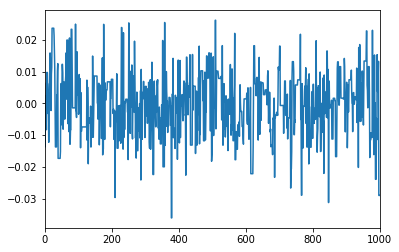

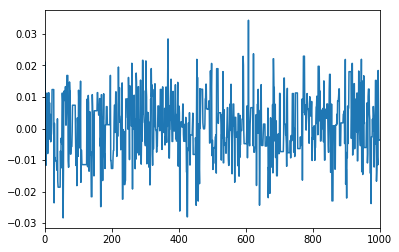

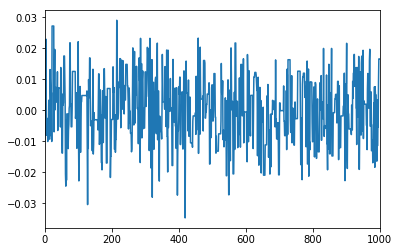

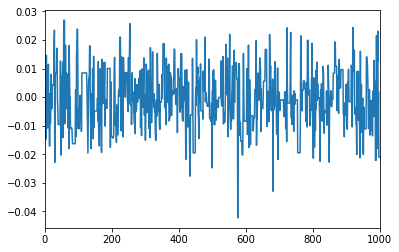

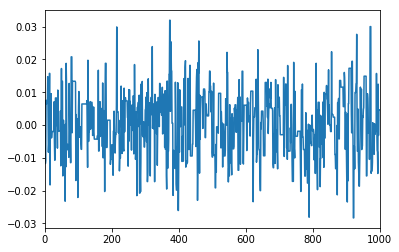

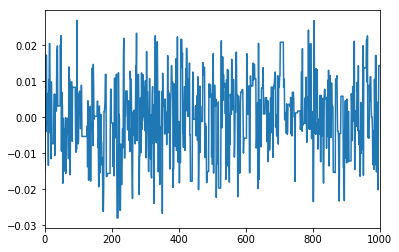

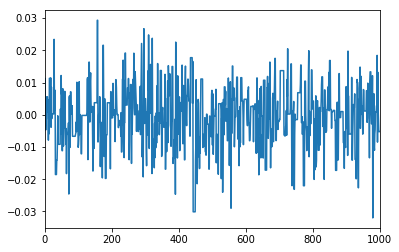

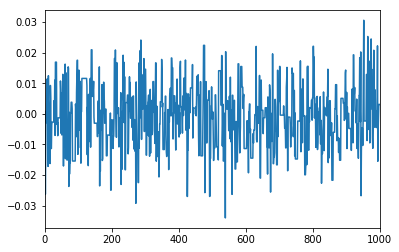

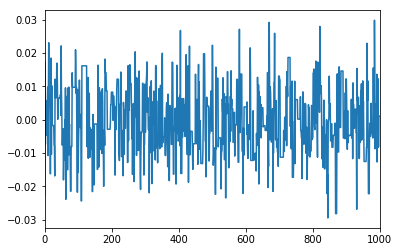

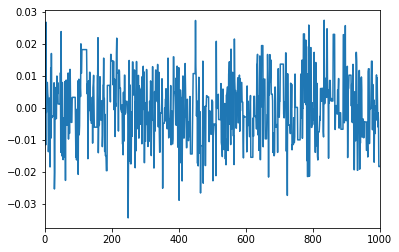

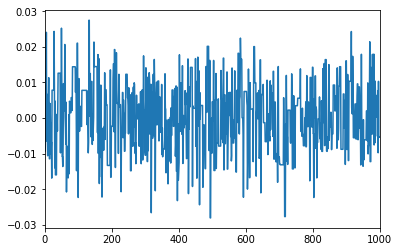

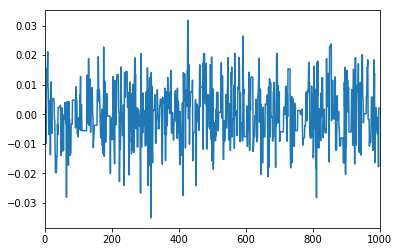

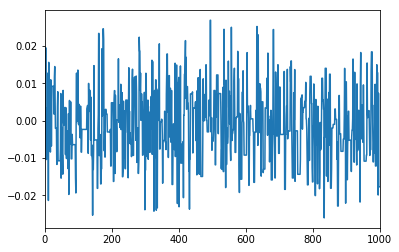

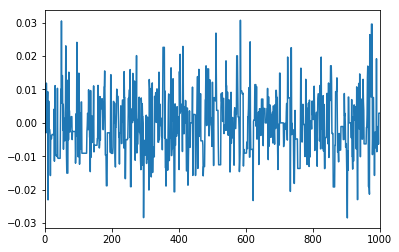

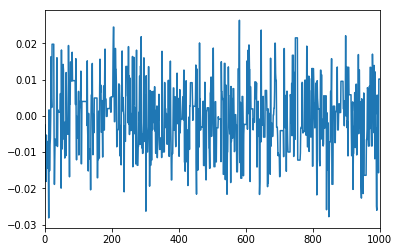

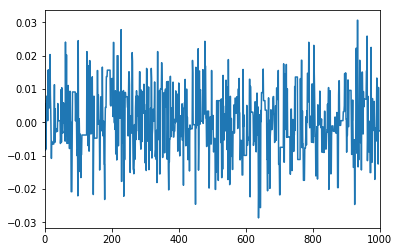

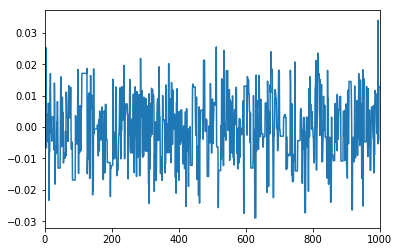

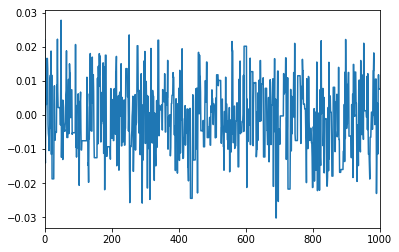

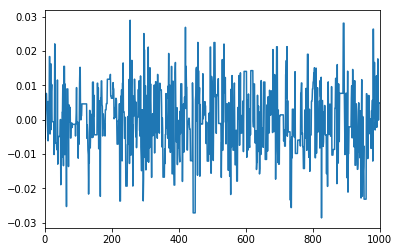

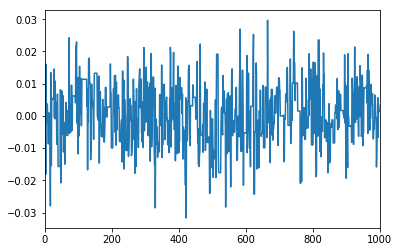

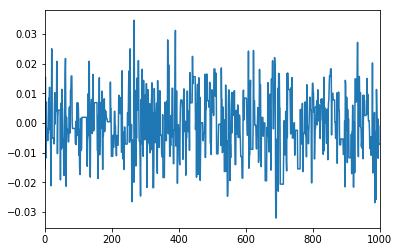

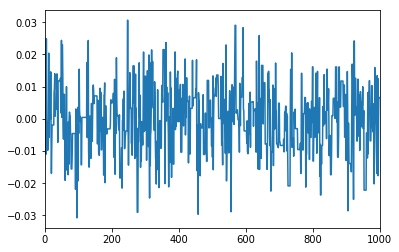

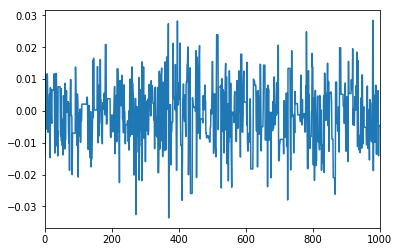

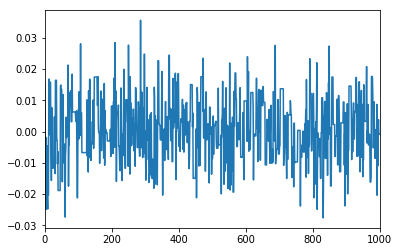

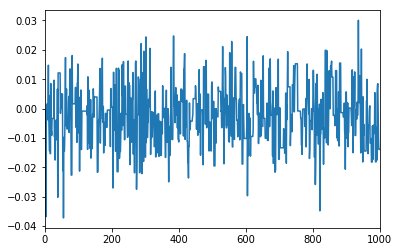

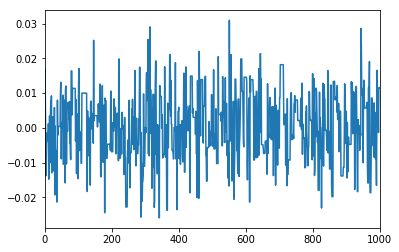

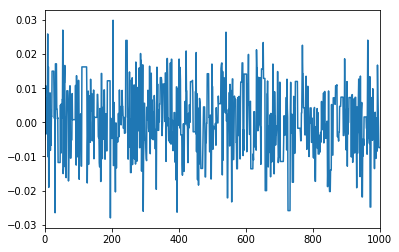

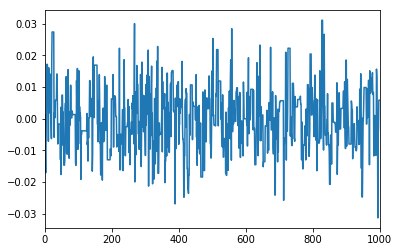

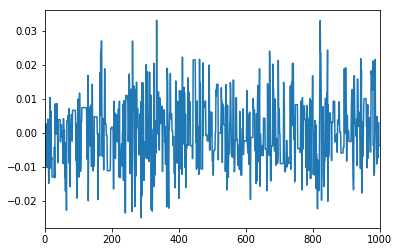

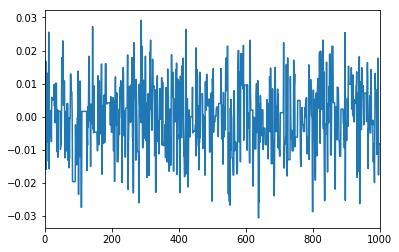

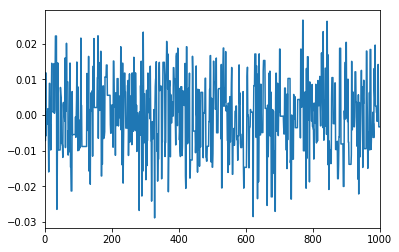

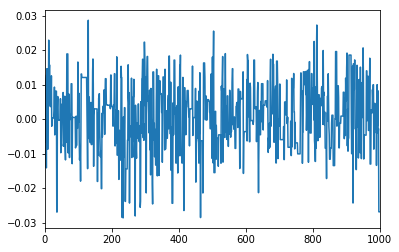

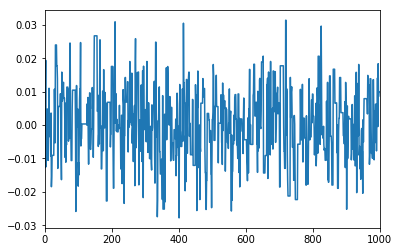

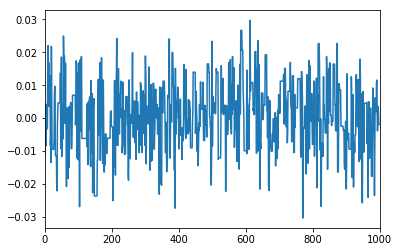

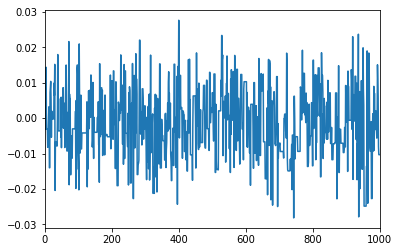

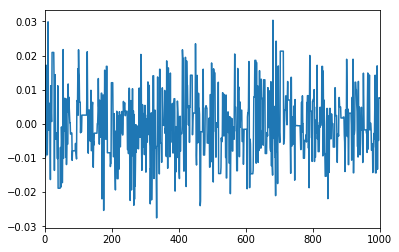

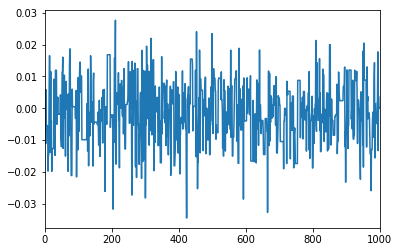

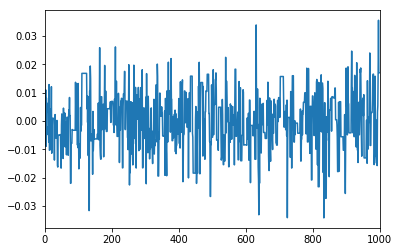

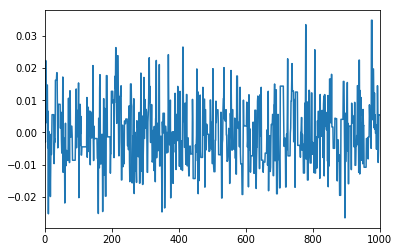

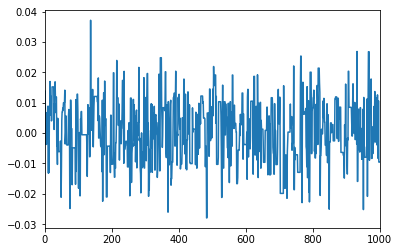

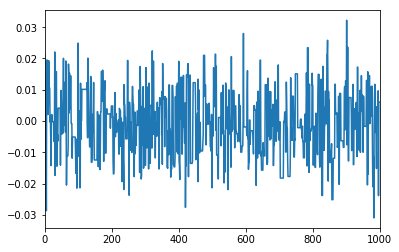

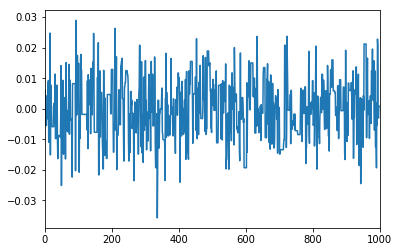

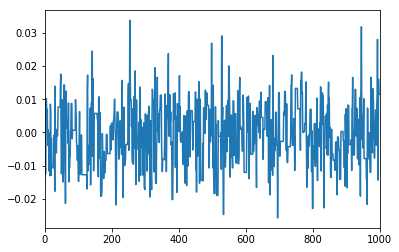

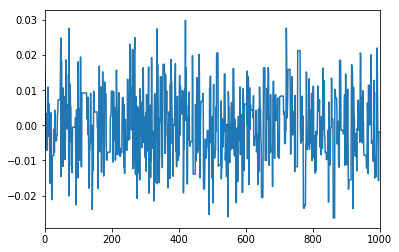

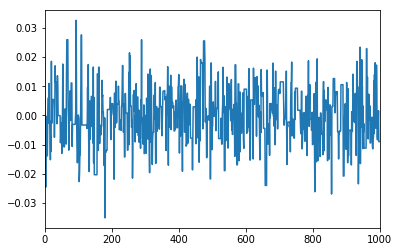

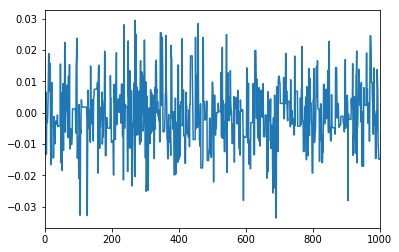

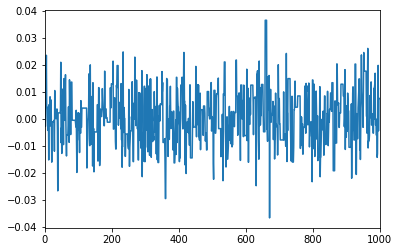

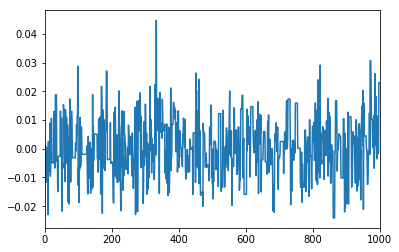

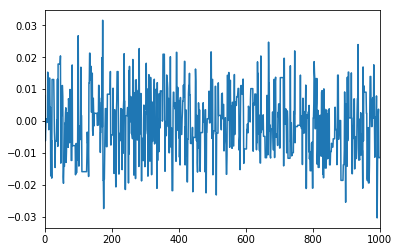

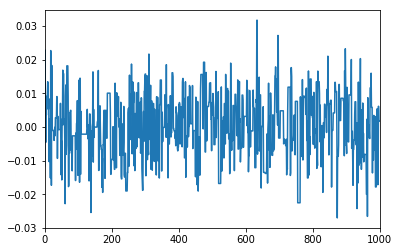

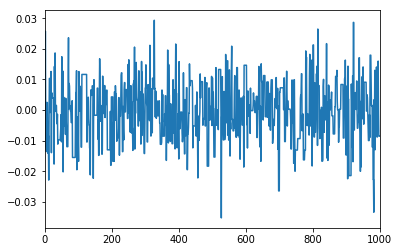

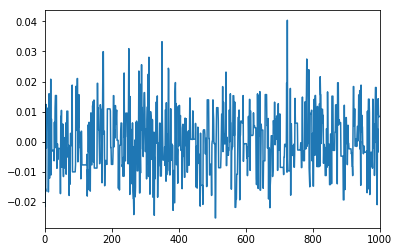

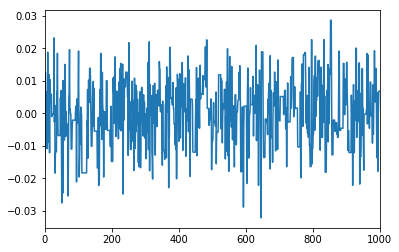

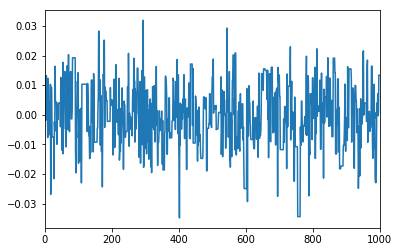

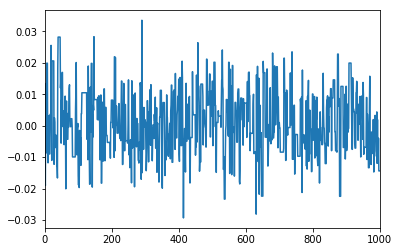

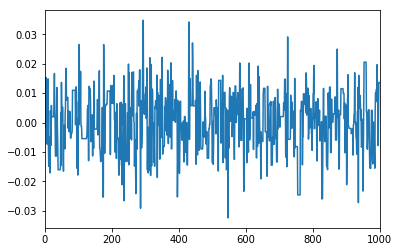

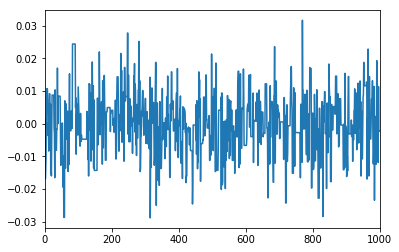

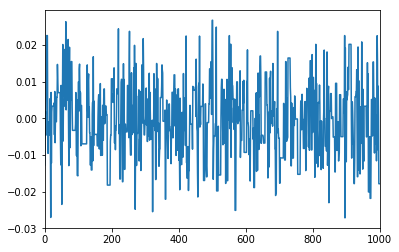

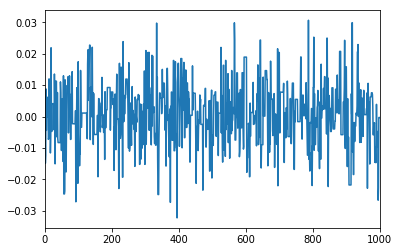

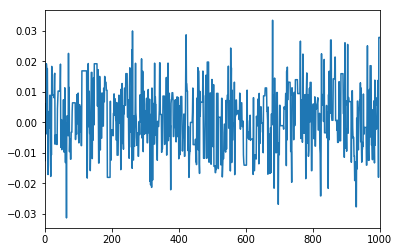

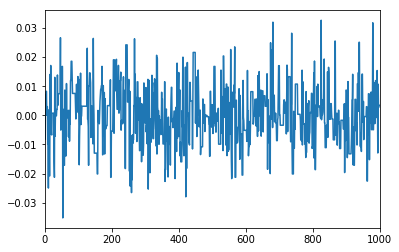

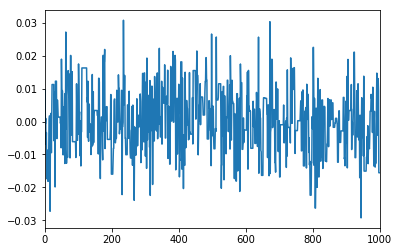

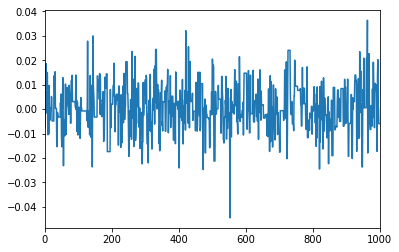

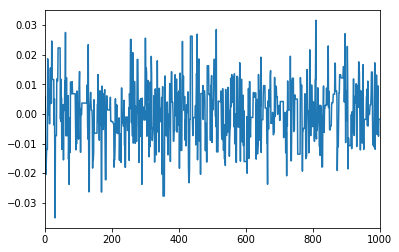

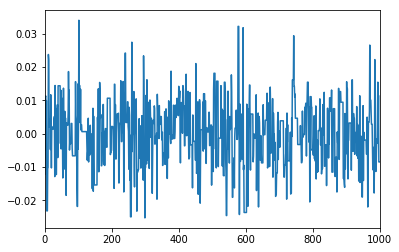

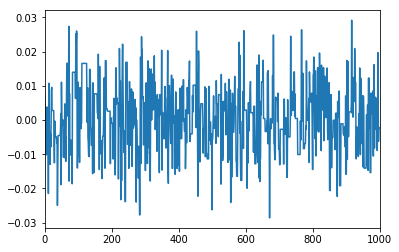

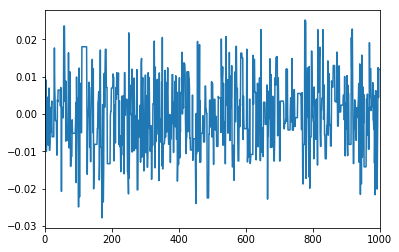

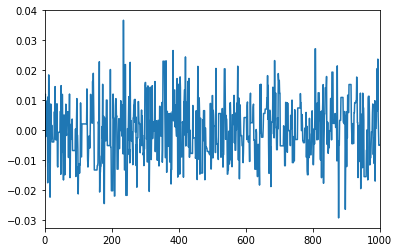

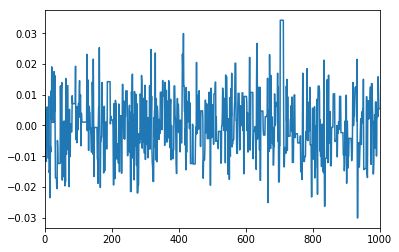

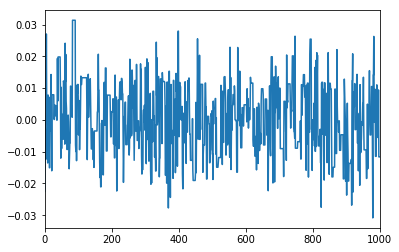

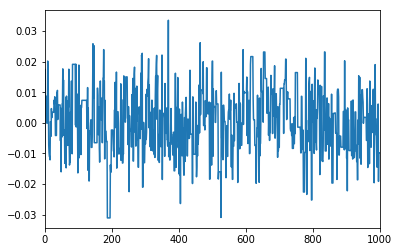

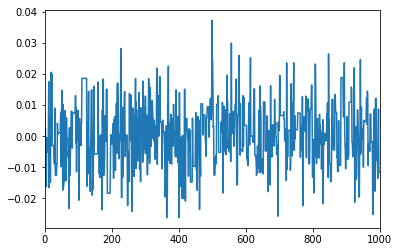

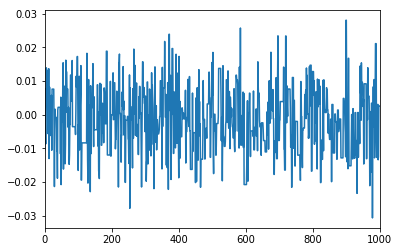

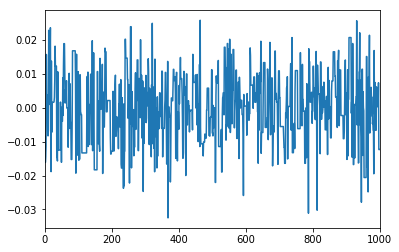

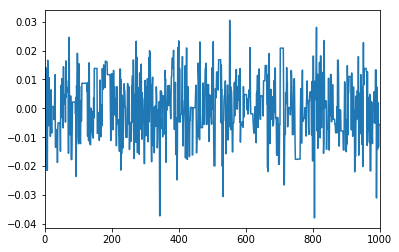

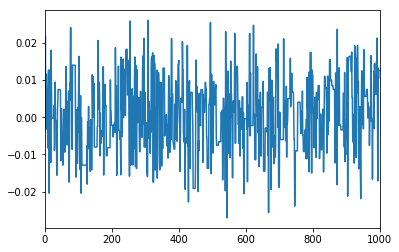

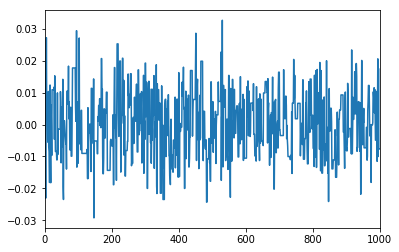

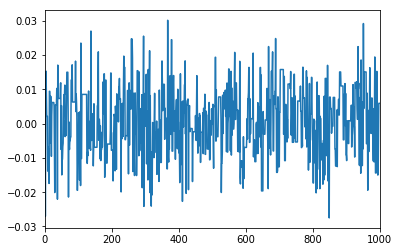

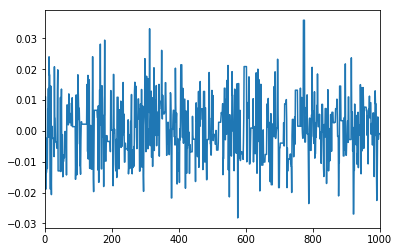

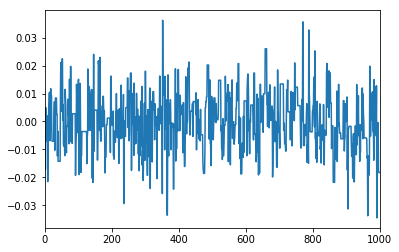

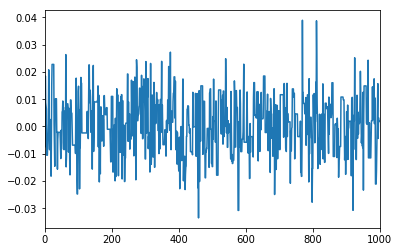

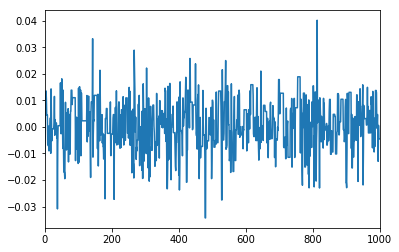

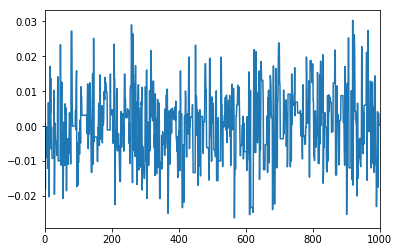

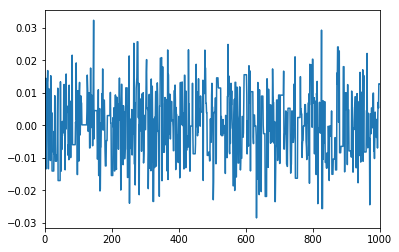

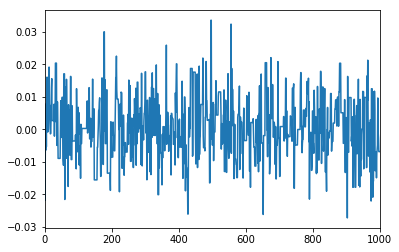

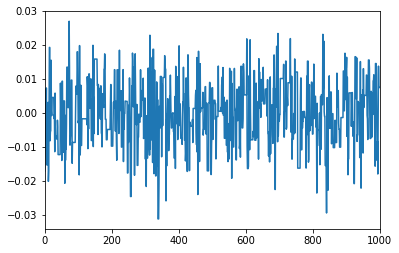

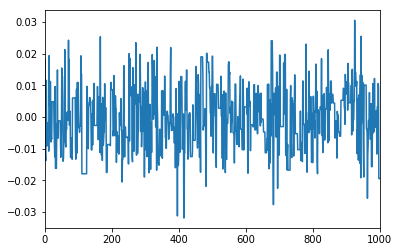

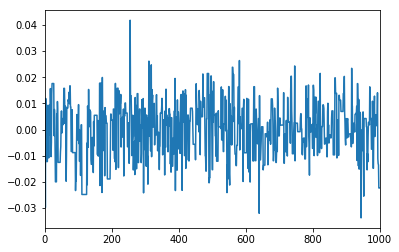

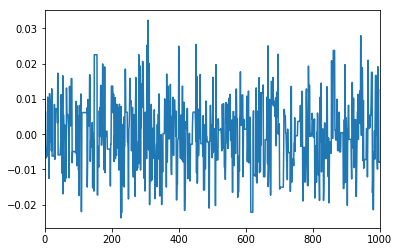

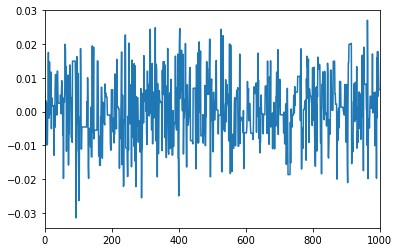

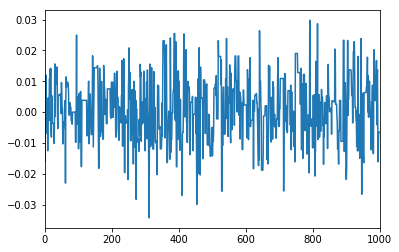

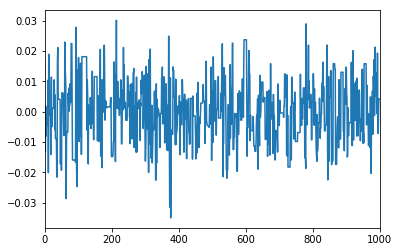

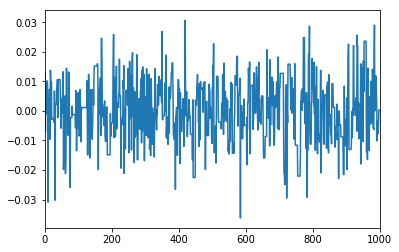

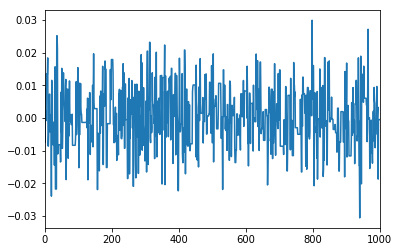

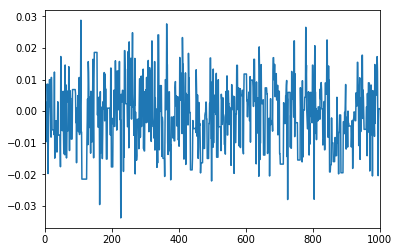

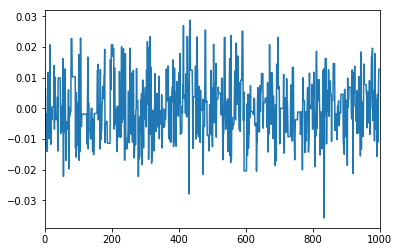

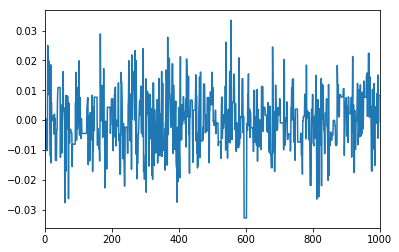

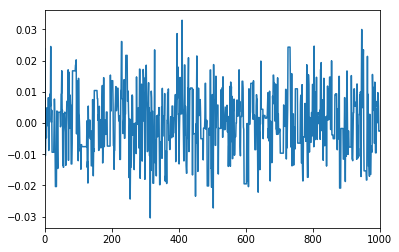

In [29]:
for i in range(tt.shape[1]):
    sns.tsplot(tt[-1000:,i])
    plt.show()